# Creating and Training a CNN

Authors: Matthew Gilley, John Morgan and Nicolas Null<br>
Written in Fall 2021
<hr>


### Import Libraries

In [685]:
import pickle
import gzip
import os
import datetime as dt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

### Load Dataloaders Into Notebook
Dataloaders were created and separated in using the load_cropped_images notebook. To control the sizes of each dataset, you must run that notebook again.

In [686]:
here = os.getcwd()

with gzip.open(os.path.join(here, 'test_cropped_dataloader.pkl')) as file:
    test_dataloader = pickle.load(file)


with gzip.open(os.path.join(here, 'validate_cropped_dataLoader.pkl')) as file:
    validate_dataloader = pickle.load(file)
    
with gzip.open(os.path.join(here, 'train_cropped_dataloader.pkl')) as file:
    train_dataloader = pickle.load(file)

### Count the Number of Noise and RFI Instances in each Dataset
This step is done so that the output files can include the exact number of RFI and Noise in each dataset. This may help in understanding the data when we review the output files created by testing. This is accomplished by iterating through each dataloader and counting the number of noise labels and the number of rfi labels.

In [687]:
# getting test dataset info
test_noise = 0
test_rfi = 0
for (images, labels) in test_dataloader.dataset:
    if labels == 0:
        test_noise+=1
    else:
        test_rfi+=1

print('Test:')
print(f'noise: {test_noise}')
print(f'rfi: {test_rfi}')
print(f'total {len(test_dataloader.dataset)}')

# getting train dataset info
train_noise = 0
train_rfi = 0
for (images, labels) in train_dataloader.dataset:
    if labels == 0:
        train_noise+=1
    else:
        train_rfi+=1

print('\nTrain: ')
print(f'noise: {train_noise}')
print(f'rfi: {train_rfi}')
print(f'total {len(train_dataloader.dataset)}')

# getting validate dataset info
validate_noise = 0
validate_rfi = 0
for (images, labels) in validate_dataloader.dataset:
    if labels == 0:
        validate_noise+=1
    else:
        validate_rfi+=1

print('\nValidate: ')
print(f'noise: {validate_noise}')
print(f'rfi: {validate_rfi}')
print(f'total {len(validate_dataloader.dataset)}')

Test:
noise: 95
rfi: 78
total 173

Train: 
noise: 391
rfi: 411
total 802

Validate: 
noise: 88
rfi: 84
total 172


### Creating a CNN

#### Overview
A Convolutional Neural Network (CNN) is a classifier that works with images. A CNN consists of multiple layers starting with the convolutional layers which identify high level features of the image and ending with a Deep Neural Network (DNN) which classify the image. A very insightful, interactive breakdown of the different components can be found <a href="https://poloclub.github.io/cnn-explainer/">here.</a>

<br>
CNN Diagram<br>
<a href="https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53">Source</a>
<br>
<img src="notebook_images/CNN_diagram.png" width="400px">

#### Convolutional Layers
Each convolutional layer begins with convolution where a kernel is run over the input image. Kernels extract features from the images that will help differentiate between different types of images. These kernels are modified each epoch of the training to help extract more important features to the classification. Parameters of the kernels that can be modified during training include padding, kernel size, stride and weights (values inside of the kernel).
<br><br>
Animation showing kernal running over a 2-dimensional array<br>
<a href="https://analyticsindiamag.com/convolutional-neural-network-image-classification-overview/"> Source</a><br>
<img src="notebook_images/conv_layer.gif" width="300px">

The next step in each convolutional layer is the activation function. In our case we are using the ReLU function. The ReLU function is currently the modern standard for activation functions. Is is very computationally cheap and proven to be just as good as sigmoid and tanh functions. It also does not allow a negative output.

<br>
Screenshot of common activation functions<br>
<a href="https://www.quora.com/What-is-ReLU-and-Softmax">Source</a>
<br>
<img src="notebook_images/activation_functions.png" width="300px">


The final step in the convolutional layer is the pooling function. The pooling function helps reduce the size of the activations and in turn the size of the overall network while still keeping the important values. The pooling layer is set up by the stride (the distance the kernel moves), the size of the kernel, and the type of pooling (typically either average or max). In the case of a 2x2 kernel with stride 2, 75% of the activation values are discarded. This helps reduce the complexity of the overall model as well as avoiding overfitting.

<br>
Example of a maxpool of size 2x2 and stride 2<br>
<a href="https://www.geeksforgeeks.org/cnn-introduction-to-pooling-layer/">Source</a>
<br>
<img src="notebook_images/pooling_function.png" width="300px">

#### Deep Neural Network
Here we use a neural net with 2 fully connected hidden layers. The input will the the results from the final convolutional layer. The outputs will be the classification of the image.

<br>
Diagram of a fully connected DNN<br>
<a href="https://www.researchgate.net/figure/Example-of-fully-connected-neural-network_fig2_331525817">Source</a><br>
<img src="notebook_images/DNN_diagram.png" width="300px">

### Our Model

<img src="notebook_images/Conv_diagram.png" alt="Our Model"><br>**This figure is generated by adapting the code from <a href="https://github.com/gwding/draw_convnet">https://github.com/gwding/draw_convnet<a><br><br>

Our model is very heavily based off of a network created while taking <a href="https://www.udacity.com/course/deep-learning-pytorch--ud188">this Udacity Course</a>. It contains 3 convolutional layers and a DNN with 2 fully connected hidden layers. Knowing that this structure was able to correctly classify different images in the CIFAR dataset made us believe it would work very well in our case of astronomical data screenshots. We first define all of the different layers that will be used in the __init__ method. Then in the forward function we lay out exactly how the image will progress through each of the layers we designed.

In [688]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # crates all of the Layer types used in CNN 

        # convolutional layers
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)

        # Pooling Layer
        self.pool = nn.MaxPool2d(2,2)
        
        # DNN layers
        self.fc1 = nn.Linear(64*32*32, 512)
        self.fc2 = nn.Linear(512,2)

        # Dropout to avoid overfitting
        self.dropout = nn.Dropout(0.25)

        

    def forward(self, x): # forward is the method called to run the image through the network
        x = self.pool(F.relu(self.conv1(x))) # convolutional layer 1
        x = self.pool(F.relu(self.conv2(x))) # convolutional layer 2
        x = self.pool(F.relu(self.conv3(x))) # convolutional layer 3
        x = x.view(-1, 64*32*32) # flatten results from 2d to 1d
        x = self.dropout(x)
        x = F.relu(self.fc1(x)) # DNN layer 1
        x = self.dropout(x)
        x = self.fc2(x) # DNN layer 2

        return x


### Create Model

In [689]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Creating Criterion and Optimizer
Criterion and optimizer are used to make the model better during training. The criterion uses cross entropy loss to calculate the errors in the model. The optimizer we chose to use was stochastic gradient descent. This uses loss calculated by the criterion to gradually minimize the errors in the model.

<br>
Gradient Descent Animation<br>
<a href="https://blog.paperspace.com/intro-to-optimization-in-deep-learning-gradient-descent/">Source</a><br>
<img src="notebook_images/gradient_descent.gif" width="400px">

In [690]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### CUDA Control
This allows us to control whether or not we run the training on the GPU.

In [691]:
# SET THIS TO TRUE IF YOU WANT TO RUN IN CPU NO MATTER WHAT
force_cpu = False

use_cuda = False #don't touch this
if torch.cuda.is_available() and not force_cpu:
    use_cuda = True
    
device = torch.device("cuda:0" if use_cuda else "cpu")

### Output File Formatting
In this block we name an output file based on the time and date that the following cell is run. We also record the name of the file, size of the datasets and corresponding distributions of the classes, the model architecture, and the device (either CUDA or CPU) that was used to run this model.

In [692]:

# get file name 
date_n_time = dt.datetime.now()
time_stamp_created= date_n_time.strftime('%d%b%y-%H_%M_%S')
file_name = 'output_files/'+ time_stamp_created + '-crop_test_results.txt'



original_stdout = sys.stdout
# This creates file and starts saving info to it
with open(file_name, 'w') as file:
    sys.stdout = file
    print(file_name.replace('.txt', '')+':')
    print("\nSize of datasets:")
    print(f'Train Size: Total={len(train_dataloader.dataset)}  Noise={train_noise}  RFI={train_rfi}')
    print(f'Test Size: Total={len(test_dataloader.dataset)}  Noise={test_noise}  RFI={test_rfi}')
    print(f'Validate Size: Total={len(validate_dataloader.dataset)}  Noise={validate_noise}  RFI={validate_rfi}')
    print('\nMODEL:')
    print(model)
    print(f'\nDevice Used: {device}')
    sys.stdout = original_stdout

### Training the Model
We force all needed resources (the model and each image/label) to the device determined earlier. We then run through each epoch of training. Each image is run through the network forwards to calculate the loss using the criterion. Then, the model is modified using the optimizer. Each epoch's loss is calculated with the validation set so we can track the improvement of each epoch. The total training time and validation loss of each epoch are recorded into the output file.

In [693]:
# push needed info to cuda
if use_cuda:
    model.cuda()
else:
    model.cpu()
criterion.cpu()
num_epochs = 20

validation_loss_min = -float('inf')

# Start timer
start_timer = time.perf_counter()

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}:')
    train_loss = 0.0
    validation_loss = 0.0
    train = 1
    num_train_batches = len(train_dataloader)
    model.train()
    for image, label in train_dataloader:
        # Sends stuffs to cuda if available
        image = image.to(device)
        label = label.to(device)
        #print("Training Batch:", train, "of", num_train_batches)
        train += 1
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*image.size(0)

    num_validate_batches = len(validate_dataloader)
    validate = 1
    model.eval()
    for image, label in validate_dataloader:
        # Sends stuffs to cuda if availible
        image = image.to(device)
        label = label.to(device)
        #print("Validation Batch:", validate, "of", num_validate_batches)
        validate += 1
        output = model(image)
        loss = criterion(output, label)
        validation_loss += loss.item()*image.size(0)

    train_loss = train_loss/len(train_dataloader.dataset)
    validation_loss = validation_loss/len(validate_dataloader.dataset)

    # PRINT OUTPUTS TO FILE
    original_stdout = sys.stdout
    with open(file_name, 'a') as file:
        sys.stdout = file
        print('\nRESULTS:')
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, validation_loss))
        print('\n')
        sys.stdout = original_stdout
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, validation_loss))

stop_timer = time.perf_counter()
original_stdout = sys.stdout
with open(file_name, 'a') as file:
    sys.stdout = file
    print(f"TIME TO TRAIN MODEL: {stop_timer-start_timer}")
    sys.stdout = original_stdout

Epoch 1:
Training Batch: 1 of 51
Training Batch: 2 of 51
Training Batch: 3 of 51
Training Batch: 4 of 51
Training Batch: 5 of 51
Training Batch: 6 of 51
Training Batch: 7 of 51
Training Batch: 8 of 51
Training Batch: 9 of 51
Training Batch: 10 of 51
Training Batch: 11 of 51
Training Batch: 12 of 51
Training Batch: 13 of 51
Training Batch: 14 of 51
Training Batch: 15 of 51
Training Batch: 16 of 51
Training Batch: 17 of 51
Training Batch: 18 of 51
Training Batch: 19 of 51
Training Batch: 20 of 51
Training Batch: 21 of 51
Training Batch: 22 of 51
Training Batch: 23 of 51
Training Batch: 24 of 51
Training Batch: 25 of 51
Training Batch: 26 of 51
Training Batch: 27 of 51
Training Batch: 28 of 51
Training Batch: 29 of 51
Training Batch: 30 of 51
Training Batch: 31 of 51
Training Batch: 32 of 51
Training Batch: 33 of 51
Training Batch: 34 of 51
Training Batch: 35 of 51
Training Batch: 36 of 51
Training Batch: 37 of 51
Training Batch: 38 of 51
Training Batch: 39 of 51
Training Batch: 40 of 51


### Test Model With Unseen Data
Now that the model is trained, we can measure the performance of the model using the test dataloader. Since we are not modifying the model, we run this set with no gradations. This way we only test the model, not modify. We also can calculate the confusion matrix, accuracy score and f1 score to better visualize the performance of this model. All of these statistics are saved to the output file.

Test Batch: 1 of 11
Test Batch: 2 of 11
Test Batch: 3 of 11
Test Batch: 4 of 11
Test Batch: 5 of 11
Test Batch: 6 of 11
Test Batch: 7 of 11
Test Batch: 8 of 11
Test Batch: 9 of 11
Test Batch: 10 of 11
Test Batch: 11 of 11
Confusion Matrix:
 [[94  1]
 [ 3 75]]
Accuracy Score: 0.976878612716763
f1 Score: 0.976878612716763


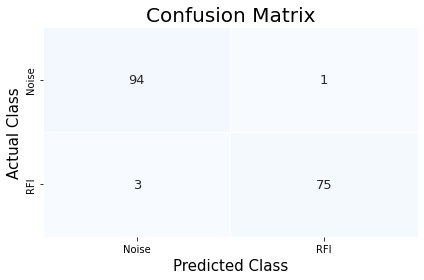

Test Loss: 0.05120708961362783


In [694]:
# force to CPU
device = torch.device('cpu')
model.cpu()

num_test_batches = len(test_dataloader)
test = 1
test_loss = 0.0
model.eval()
predicted_classes = np.empty(0,dtype="uint8")
actual_classes = np.empty(0,dtype="uint8")
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.to(device)
        label = label.to(device)
        #print("Test Batch:", test, "of", num_test_batches)
        test += 1
        output = model(image)
        loss = criterion(output, label)
        test_loss += loss.item()*image.size(0)
        
        predicted_classes = np.append(predicted_classes, np.argmax(output, axis=1))
        actual_classes = np.append(actual_classes, label)
        
accuracy = accuracy_score(actual_classes, predicted_classes)
confusion_matrix = cm(actual_classes, predicted_classes)
f1 = f1_score(actual_classes,predicted_classes, average='micro')
print(f"Confusion Matrix:\n {confusion_matrix}")
print(f"Accuracy Score: {accuracy}")
print(f'f1 Score: {f1}')

## MAKES CONFUSION MATRIX GRAPHIC
plt.title("Confusion Matrix", fontsize=20)

palette = sns.set_palette('pastel')

sns.heatmap(cm(actual_classes, predicted_classes),cbar=False,annot=True, annot_kws={'size': 13}, fmt="d", linewidth=.5, robust=True, xticklabels=['Noise','RFI'], yticklabels=['Noise', 'RFI'], cmap='Blues', vmax = 3225, vmin = 19)

plt.xlabel('Predicted Class', fontsize=15)
plt.ylabel('Actual Class', fontsize=15)
plt.tight_layout()
plt.savefig(file_name.replace('.txt', '.jpg'))
plt.show()

## END OF CONFUSION MATRIX GRAPHIC

test_loss = test_loss/len(test_dataloader.dataset)
print("Test Loss:", test_loss)

original_stdout = sys.stdout
with open(file_name, 'a') as file:
    sys.stdout = file
    print()
    print("RESULTS:")
    print(f"Confusion Matrix:\n {confusion_matrix}")
    print(f"Accuracy Score: {accuracy}")
    print(f'f1 Score: {f1}')
    print("Test Loss:", test_loss)
    sys.stdout = original_stdout


### Save the Model

In [695]:
model_path = "output_files/" + time_stamp_created + "-crop_model.pth"

torch.save(model.state_dict(), model_path)